In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import chamfer_loss
from fspool import FSPool
from model import FSEncoder
from model import MaxEncoder
from MnistSet import MNISTSet
from MnistSet import get_loader

### Preparamos los datos de entreno y test

In [2]:
batch_size = 32

In [3]:
train_loader = get_loader(
            MNISTSet(train=True, full=True), batch_size=batch_size, num_workers=4)

In [4]:
test_loader = get_loader(
            MNISTSet(train=False, full=True), batch_size=batch_size, num_workers=4)

In [5]:
from time import sleep
from tqdm import tqdm

In [6]:
set_channels = 2
set_size = 342
  
hidden_dim = 32
iters = 10
latent_dim = 16
lr = 0.001
n_epochs = 100
net = MaxEncoder(set_channels,latent_dim,hidden_dim)

In [7]:
net

MaxEncoder(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [8]:
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=0.001)

In [9]:
#net = net.cuda()

In [10]:
net.train()
for epoch in range(n_epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
        for i, sample in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input, target_set, target_mask = map(lambda x: x, sample)
            optimizer.zero_grad()
            output = net(target_set,target_mask)
            loss = F.cross_entropy(output, input)
            acc = (output.max(dim=1)[1] == input).float().mean()
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

Epoch 99: 100%|███████████████████████████████████████████████| 1875/1875 [01:13<00:00, 25.53batch/s, acc=84.4, loss=0.265]


In [11]:
net.eval()
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {1}")
        input, target_set, target_mask = map(lambda x: x, sample)
        output = net(target_set,target_mask)
        loss = F.cross_entropy(output, input)
        acc = (output.max(dim=1)[1] == input).float().mean()
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

Epoch 1: 100%|██████████████████████████████████████████████████| 312/312 [00:08<00:00, 37.03batch/s, acc=100, loss=0.0594]


In [12]:
#torch.save(net.state_dict(),'model_max_encoder.pth')

In [32]:
model = torch.load('model_max_encoder.pth' ,map_location=torch.device('cpu'))
miNet = MaxEncoder(set_channels,latent_dim,hidden_dim)

In [34]:
miNet.load_state_dict(torch.load('model_max_encoder.pth' ,map_location=torch.device('cpu')))

<All keys matched successfully>

In [35]:
miNet

MaxEncoder(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [36]:
miNet.eval()
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {1}")
        input, target_set, target_mask = map(lambda x: x, sample)
        output = miNet(target_set,target_mask)
        loss = F.cross_entropy(output, input)
        acc = (output.max(dim=1)[1] == input).float().mean()
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

Epoch 1: 100%|███████| 312/312 [00:08<00:00, 36.79batch/s, acc=87.5, loss=0.269]


In [37]:
import seaborn as sn
import matplotlib
import matplotlib.pyplot as pyplot
import numpy as np

In [38]:
miNet

MaxEncoder(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

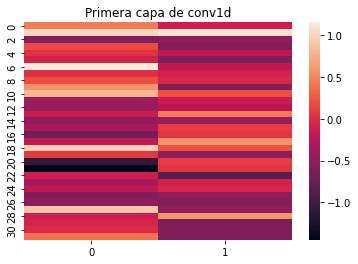

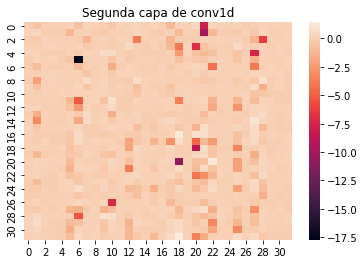

In [39]:
filters= miNet.conv[0].weight
data = filters.squeeze(2).detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Primera capa de conv1d")
pyplot.show()
filters= miNet.conv[2].weight
data = filters.squeeze(2).detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Segunda capa de conv1d")
pyplot.show()

torch.Size([32, 32])


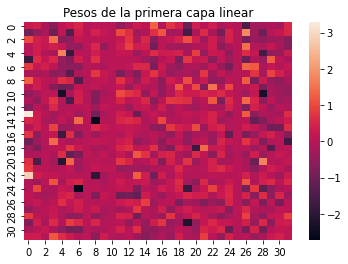

In [40]:
filters= miNet.lin[0].weight
print(filters.shape)
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Pesos de la primera capa linear")
pyplot.show()

torch.Size([16, 32])


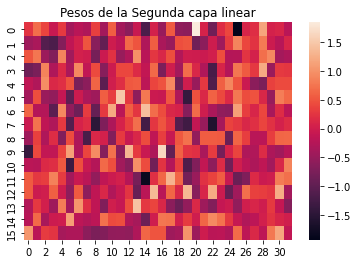

In [41]:
filters= miNet.lin[2].weight
print(filters.shape)
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Pesos de la Segunda capa linear")
pyplot.show()

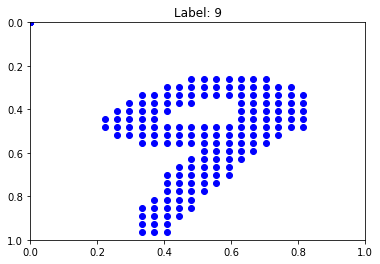

torch.Tensor

In [292]:
dataset = MNISTSet(train=False, full=True)
expected, sample,mask_sample = dataset[9]
x = sample[1, :]
y = sample[0, :]
pyplot.scatter(x, y,color ='b')
pyplot.axis([0, 1, 1, 0])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()
sample = sample.unsqueeze(0)
mask_sample = mask_sample.unsqueeze(0)
expected = torch.tensor(expected).unsqueeze(0)
type(sample)

In [293]:
with torch.no_grad():
    pred = miNet(sample,mask_sample)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),expected.item()))

We obtained 9, and the expected is: 9


In [130]:
class Model1(nn.Module):
    def __init__(self, input_channels, output_channels, dim, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_channels, dim, 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(dim, dim, 1),
        )
        self.lin = nn.Sequential(
            nn.Linear(dim, dim, 1),
            nn.ReLU(inplace=True),
            nn.Linear(dim, output_channels, 1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(output_channels, output_channels),
            nn.ReLU(),
            nn.Linear(output_channels, 10),
        )

    def forward(self, x, n_points, *args):
        x = self.conv(x)
        #x = x.max(2)[0]
        #x = self.lin(x)
        return x

In [131]:
class Model2(nn.Module):
    def __init__(self, input_channels, output_channels, dim, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_channels, dim, 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(dim, dim, 1),
        )
        self.lin = nn.Sequential(
            nn.Linear(dim, dim, 1),
            nn.ReLU(inplace=True),
            nn.Linear(dim, output_channels, 1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(output_channels, output_channels),
            nn.ReLU(),
            nn.Linear(output_channels, 10),
        )

    def forward(self, x, n_points, *args):
        x = self.conv(x)
        x = x.max(2)[0]
        #x = self.lin(x)
        return x

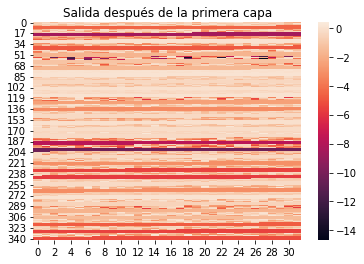

torch.Size([1, 32])


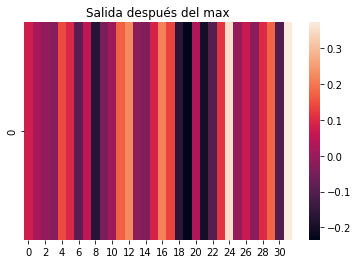

In [132]:
model1 = Model1(set_channels,latent_dim,hidden_dim)
model2 = Model2(set_channels,latent_dim,hidden_dim)
model1.conv = miNet.conv
model2.conv = miNet.conv
#print(miNet.conv[0].weight) 
#print(model1.conv[0].weight)
with torch.no_grad():
    pred = model1(sample,mask_sample)
    feature_map = pred
    data = pred.squeeze(0).detach().view(342,32).numpy()
    sn.heatmap(data, annot=False, fmt='g')
    pyplot.title("Salida después de la primera capa")
    pyplot.show()
    
    pred = model2(sample,mask_sample)
    max_map = pred
    print(pred.shape)
    data = pred.detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    pyplot.title("Salida después del max")
    pyplot.show()

In [133]:
critical = np.zeros(342)
features = feature_map.squeeze(0).detach().numpy()
maxs = max_map.squeeze(0).detach().numpy()
print(features)
print('-----------------------------------------------------------------------------')
print(maxs)

for f in range(32):
    for p in range(342):
        if features[f,p] == maxs[f]:
            critical[p] =critical[p]+1
print(critical)

[[-0.76596856 -0.59934264 -1.6639844  ... -4.51574    -4.51574
  -4.51574   ]
 [-0.52727306 -0.16553932 -1.7434342  ... -8.510403   -8.510403
  -8.510403  ]
 [-2.5915105  -3.4433398  -4.461698   ... -0.01207023 -0.01207023
  -0.01207023]
 ...
 [-0.84268475 -0.34439498 -0.11965936 ... -4.78946    -4.78946
  -4.78946   ]
 [-0.59052825 -0.4135871  -0.561066   ... -5.523575   -5.523575
  -5.523575  ]
 [-0.23812835 -1.0800612  -2.6033366  ... -5.246886   -5.246886
  -5.246886  ]]
-----------------------------------------------------------------------------
[ 0.07808201  0.01866242 -0.01207023 -0.02613536  0.14314215  0.09284754
 -0.08918304  0.05127144 -0.17036313 -0.0494963   0.00383991  0.17104594
  0.22505441 -0.02330284 -0.0390656   0.08792824  0.21151206  0.13782504
 -0.16434664 -0.23453392  0.03073306 -0.20201781 -0.10039525  0.11468244
  0.35325494 -0.00815463  0.06617416 -0.02455875  0.09985195  0.17420214
 -0.10818332  0.37265724]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [134]:
points = sample.squeeze(0).numpy()

In [337]:
sorted_critical = -np.sort(-critical)
sorted_critical_args = -np.argsort(-critical)
print(sorted_critical)
#print(sorted_critical_args)
K = 80
critical_points_x = []
critical_points_y = []
for k in range(K):
    critical_points_y.append(points[0,sorted_critical_args[k]])
    critical_points_x.append(points[1,sorted_critical_args[k]])

#criticos = critical_points.reshape(2,100)
#print(critical_points_x)
print(len(critical_points_x))
#print(critical_points_y)
print(np.sum(sorted_critical >0))
print(np.sum(sorted_critical == 6))

[6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 3. 3. 2. 2. 2. 2. 2.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

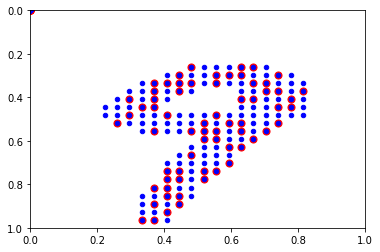

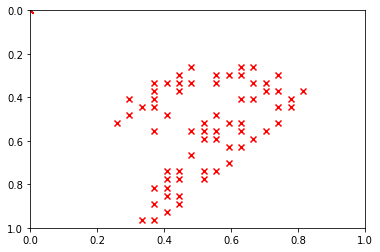

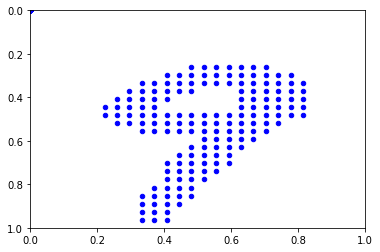

In [203]:
x1 = critical_points_x
y1 = critical_points_y
pyplot.scatter(x1, y1,marker='o',color ='r',s=50)
sam = sample.squeeze(0)
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,c ='b',s=20)
pyplot.axis([0, 1, 1, 0])
pyplot.show()

x = critical_points_x
y = critical_points_y
pyplot.scatter(x, y,marker='x',color ='r')
pyplot.axis([0, 1, 1, 0])
pyplot.show()

sam = sample.squeeze(0)
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,c ='b',s=20)
pyplot.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

In [218]:
muestraSintetica = torch.zeros(1,2,262)
a  = torch.Tensor(x1).unsqueeze(0)
k  = torch.Tensor(y1).unsqueeze(0)
print(kk.shape)
f = torch.cat((k,a),0).unsqueeze(0)
print(f.shape)
muestraSintetica = torch.cat((f,muestraSintetica,),2)
muestraSintetica.shape
mask_sintetica = torch.ones(1,342)
print(muestraSintetica.shape)
print(mask_sintetica.shape)

torch.Size([1, 80])
torch.Size([1, 2, 80])
torch.Size([1, 2, 342])
torch.Size([1, 342])


In [204]:
342-80

262

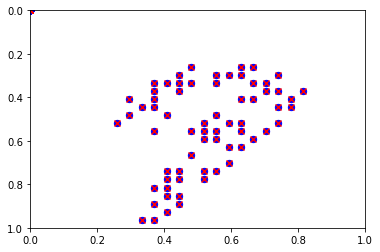

In [215]:
sam = muestraSintetica.squeeze(0)
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,c ='b',s=40)
x1 = critical_points_x
y1 = critical_points_y
pyplot.scatter(x1, y1,marker='x',color ='r')
pyplot.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

In [213]:
with torch.no_grad():
    pred = miNet(muestraSintetica,mask_sintetica)
    print(muestraSintetica.shape)
    print(mask_sintetica.shape)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),expected.item()))

torch.Size([1, 2, 342])
torch.Size([1, 342])
We obtained 9, and the expected is: 9


## Como afecta el eliminar los puntos críticos

In [341]:
import random

newSample = sample.clone().detach() #b
crit= -sorted_critical_args[:80]
print(len(crit))
for k in crit:
    #print(k)
    newSample[:,0,k] = random.uniform(0, 1)
    newSample[:,1,k] = random.uniform(0, 1)
#print(newSample)

80


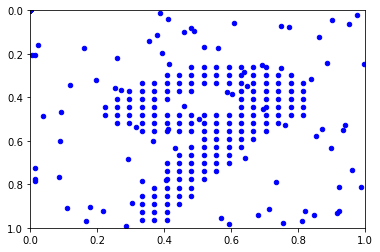

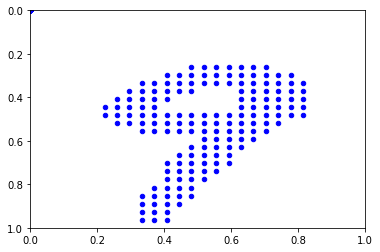

In [342]:
#En este trozo de código lo que hacemos es en las 80 primeras opciones criticas, ponemos valores aleatorios
n = newSample.squeeze(0)
x = n[1, :]
y = n[0, :]
pyplot.scatter(x, y,c ='b',s=20)
pyplot.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()
n = sample.squeeze(0)
x = n[1, :]
y = n[0, :]
pyplot.scatter(x, y,c ='b',s=20)
pyplot.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

In [344]:
with torch.no_grad():
    pred = miNet(newSample,mask_sintetica)
    print(muestraSintetica.shape)
    print(mask_sintetica.shape)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),expected.item()))

torch.Size([1, 2, 342])
torch.Size([1, 342])
We obtained 8, and the expected is: 9


## Comprobación de que funciona a la inversa, con los puntos menos informativos

In [200]:
sorted_noncritical = -np.sort(-critical)[::-1]
sorted_noncritical_args = -np.argsort(-critical)[::-1]
print(sorted_noncritical)
#print(sorted_critical_args)
K = 100
noncritical_points_x = []
noncritical_points_y = []
for k in range(K):
    noncritical_points_x.append(points[0,sorted_noncritical_args[k]])
    noncritical_points_y.append(points[1,sorted_noncritical_args[k]])

#criticos = critical_points.reshape(2,100)
#print(critical_points_x)
print(len(noncritical_points_x))
#print(critical_points_y)
print(np.sum(sorted_critical ==0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 3. 3. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.

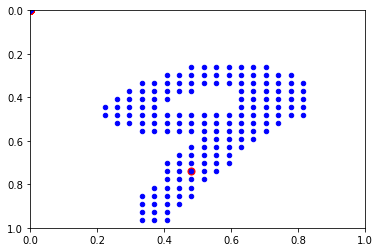

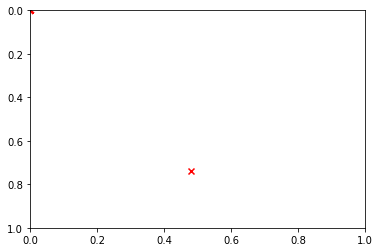

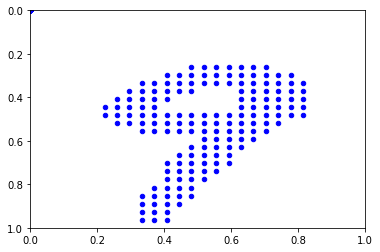

In [201]:
y1 = noncritical_points_x
x1 = noncritical_points_y
pyplot.scatter(x1, y1,marker='o',color ='r',s=50)
sam = sample.squeeze(0)
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,c ='b',s=20)
pyplot.axis([0, 1, 1, 0])
pyplot.show()

y = noncritical_points_x
x = noncritical_points_y
pyplot.scatter(x, y,marker='x',color ='r')
pyplot.axis([0, 1, 1, 0])
pyplot.show()

sam = sample.squeeze(0)
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,c ='b',s=20)
pyplot.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()